In [ ]:
include("SpinGlassCore.jl")
using .SpinGlassCore
include("../../logger/logger.jl")
using .MyLogger
include("../utils.jl")
using .Utils
using Optimisers, Logging, LinearAlgebra, Statistics, StatsBase, Random, ProgressMeter
using CairoMakie

# seed = 42
# Random.seed!(seed)

init_logger(dir="../../logs", level=:Info)
println(names(SpinGlassCore))

[:SpinGlassCore, :calc_acceptance_and_rtt, :calc_energy, :initial_state, :metropolis_sampler, :uniform_acceptance_grad_sm]


In [ ]:
N = 20
β_min = 0.1
β_max = 2
M = 15
η = 0.001
mcSteps=10^4
eqSteps=10^2
target = 0.23
epochs = 300
batch_size = 10
Jh = rand([-1.0, 1.0], N, N)
Jv = rand([-1.0, 1.0], N, N)
@info L"""
Hyperparameters of ±J model:
--------------------
system size: %$(N*N),
the number of replica: %$M,
MCS: %$mcSteps
Jh: %$Jh,
Jv: %$Jv,
"""
println("Set hyperparameters.")

Set hyperparameters.


In [ ]:
init_β_ladder = Utils.set_temperature_ladder(
    β_min, 
    β_max; 
    M=M, 
    method=:geometric
)
exchange_prob_means, _ = SpinGlassCore.calc_acceptance_and_rtt(N, init_β_ladder, Jh, Jv
)

println(init_β_ladder)
println(exchange_prob_means)

[0.09999999999999991, 0.12385989684455533, 0.153412740463439, 0.19001686208442106, 0.2353546893650251, 0.29151007546634394, 0.3610640787640993, 0.44721359549995776, 0.5539182980610751, 0.6860826325815645, 0.8497812409839361, 1.0525381684870863, 1.3036726897376782, 1.6147276486997293, 2.0]
[0.6390938695264206, 0.5505720407227651, 0.4679441007207928, 0.37985105221874654, 0.2950484643050418, 0.19315543254919595, 0.12624660094590465, 0.08535021090089044, 0.0669862864394054, 0.06051919182627709, 0.08248649405309587, 0.14268534100617808, 0.22449322133355198, 0.36898567328185367]


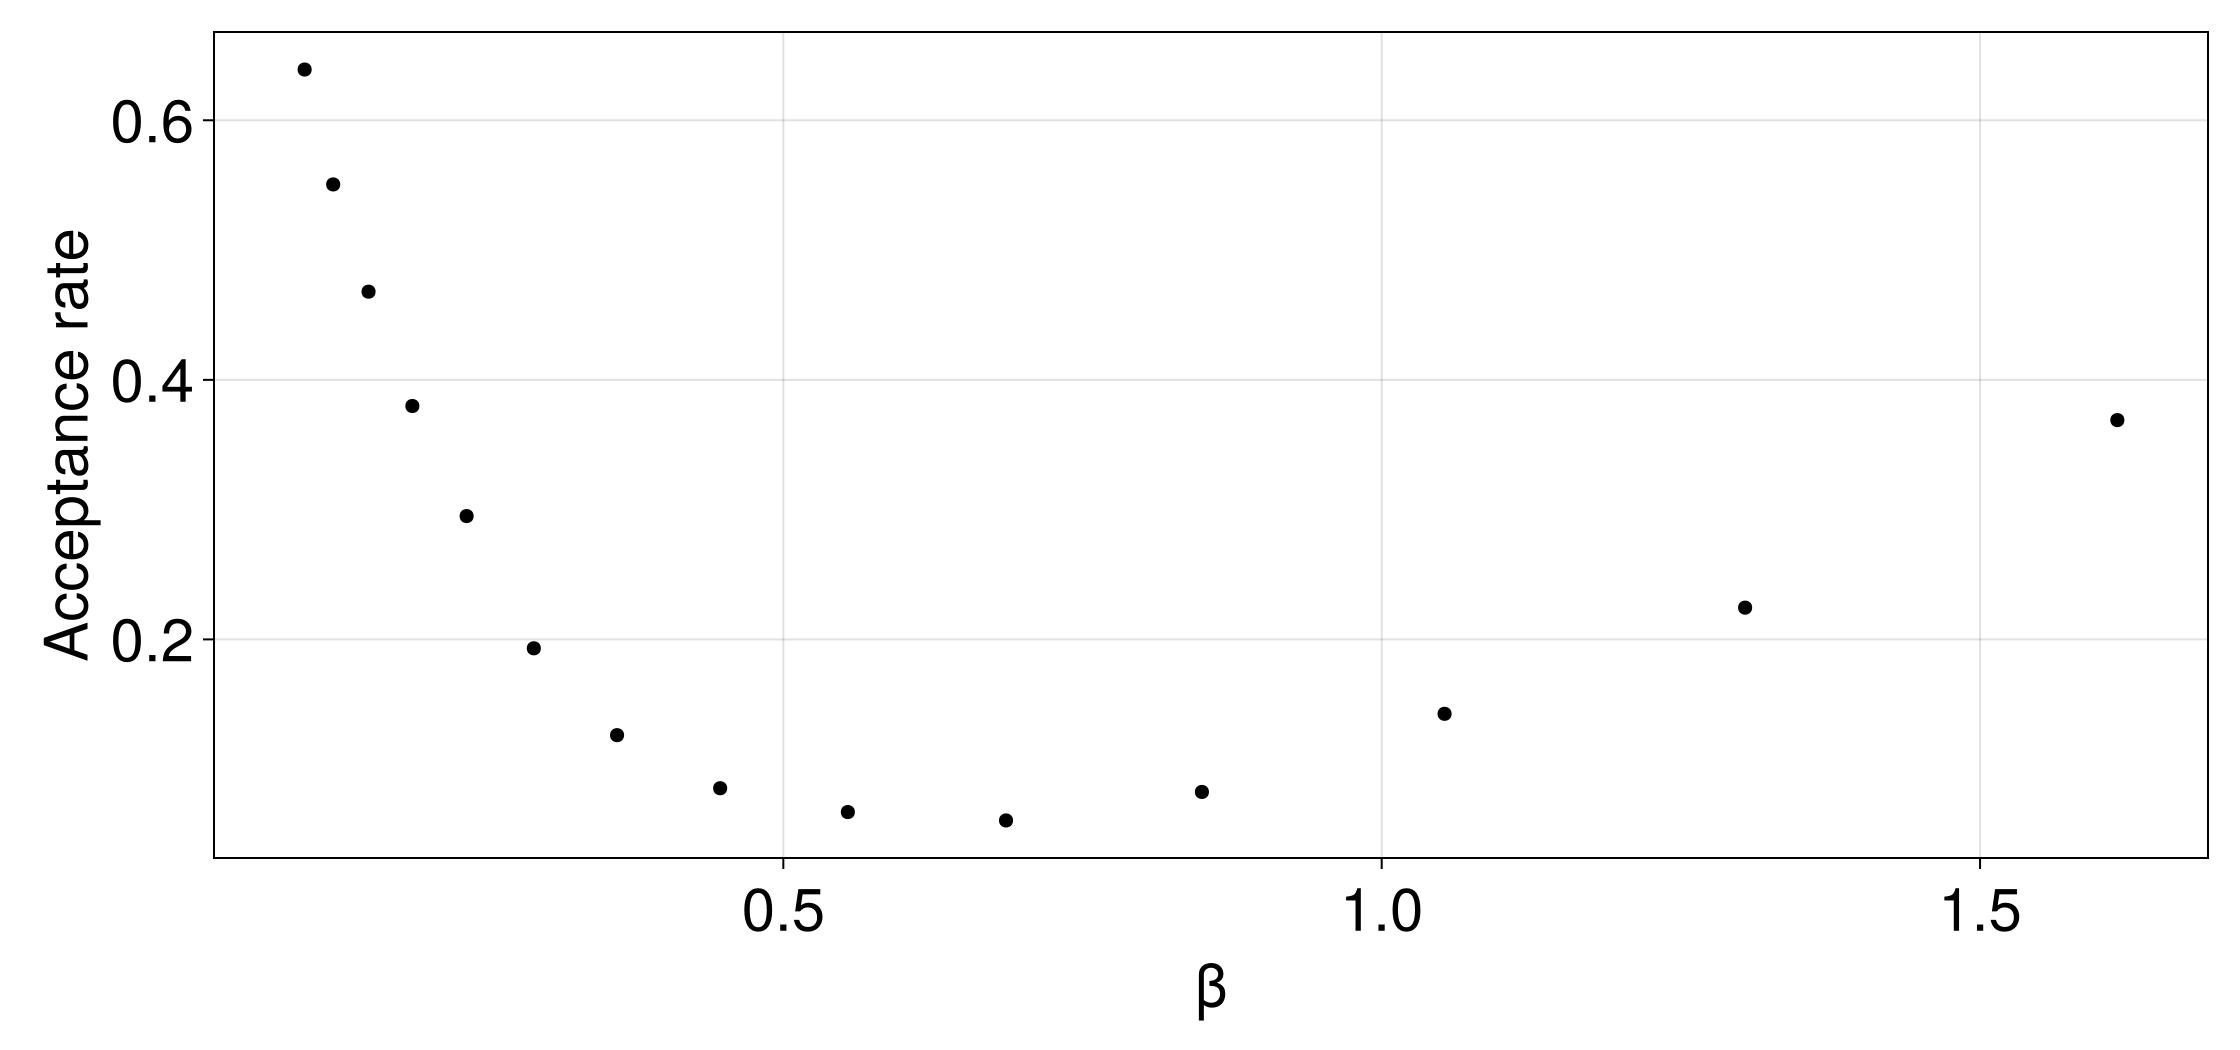

CairoMakie.Screen{IMAGE}


In [6]:
begin
    fig1 = Figure(size=(1120, 525), fontsize = 30)
    ax1 = fig1[1, 1] = Axis(fig1, xlabel="β", ylabel="Acceptance rate")
    scatter!(ax1, init_β_ladder[1:(end-1)], exchange_prob_means, color=:black, markersize=10)
    
    display(fig1)
end

In [7]:
β_ladder = deepcopy(init_β_ladder)
β_ladder_trace = [β_ladder]
optimizer = Adam(η)
setup = Optimisers.setup(optimizer, β_ladder)

exchange_prob_trace = [exchange_prob_means]
# init_loss = Statistics.mean((exchange_prob_means .- target).^2)
init_loss = Statistics.var(exchange_prob_means)
loss_trace = [init_loss]

@showprogress for epoch in 1:epochs
    samples = []
    for _ in 1:batch_size
        grad, exchange_prob_means = SpinGlassCore.score_method(
            N, 
            β_ladder,
            Jh,
            Jv;
            mcSteps=mcSteps, 
            eqSteps=eqSteps,
            exchange_interval=1,
            # target=target
        )
        push!(samples, grad)
    end
    # loss_func = Statistics.mean((exchange_prob_means .- target).^2)
    loss_func = Statistics.var(exchange_prob_means)
    grad_mean = Statistics.mean(samples)
    grad_std = Statistics.std(samples)
    # grad_mean[end] = 0.0
    setup, β_ladder = Optimisers.update(setup, β_ladder, grad_mean)

    push!(β_ladder_trace, deepcopy(β_ladder))
    push!(exchange_prob_trace, exchange_prob_means)
    push!(loss_trace, loss_func)

    formatted_grads = [
        "$(round(mean_val, digits=5))±$(round(std_val, digits=5))"
        for (mean_val, std_val) in zip(grad_mean, grad_std)
    ]
    grad_str = join(formatted_grads, ", ")

    @info """
    Epoch $epoch: 
    --------------------
    Mean Gradient: [$grad_str], 
    exchange probs: $exchange_prob_means, 
    loss function: $loss_func
    """
end

Progress: 100%|█████████████████████████████████████████| Time: 1:16:15


In [44]:
# mean_rtt_trace = []

# @showprogress for β_ladder in β_ladder_trace
#     config = SpinGlassCore.initial_state(N)
#     exchange_prob_means, all_rtts = SpinGlassCore.calc_acceptance_and_rtt(
#         N, 
#         β_ladder;
#         mcSteps=10^6,
#         eqSteps=eqSteps
#     )
#     mean_rtt = mean(all_rtts)
#     push!(mean_rtt_trace, mean_rtt)

#     @info "inverse temperature ladder: $β_ladder, mean Round-Trip-Time: $mean_rtt ± $(Statistics.std(all_rtts))"
# end

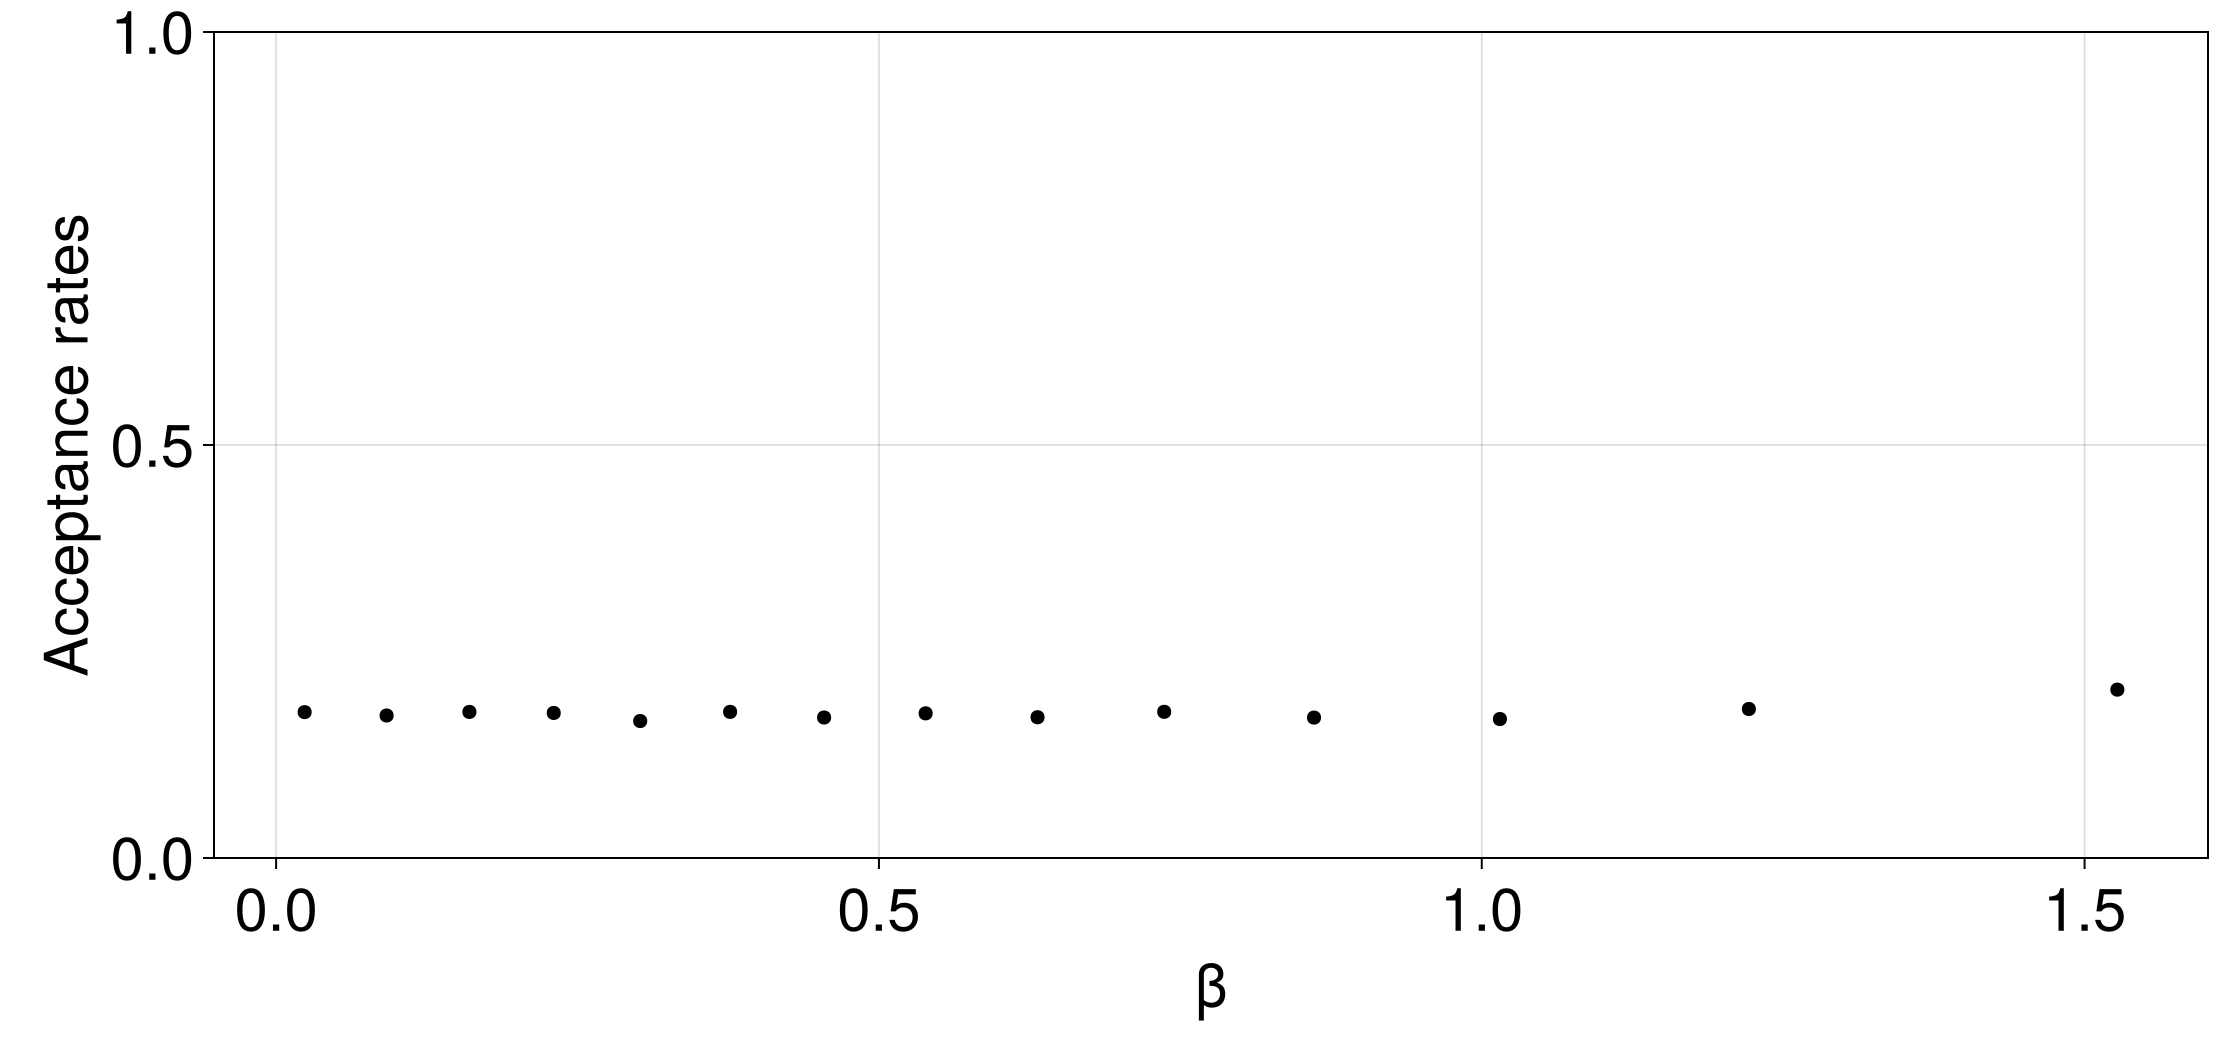

CairoMakie.Screen{IMAGE}


In [13]:
fig1 = Figure(size=(1120, 525), fontsize = 30)
ax1 = fig1[1, 1] = Axis(fig1, xlabel="β", ylabel="Acceptance rates")
ylims!(ax1, 0, 1)
scatter!(ax1, β_ladder_trace[end][1:(end-1)], exchange_prob_trace[end], color=:black, markersize=10)

display(fig1)

In [ ]:
dir = "../../plots/Edwards-Anderson_model_2d/L=$N/M=$M"
if dir !== nothing
    mkpath(dir)
end

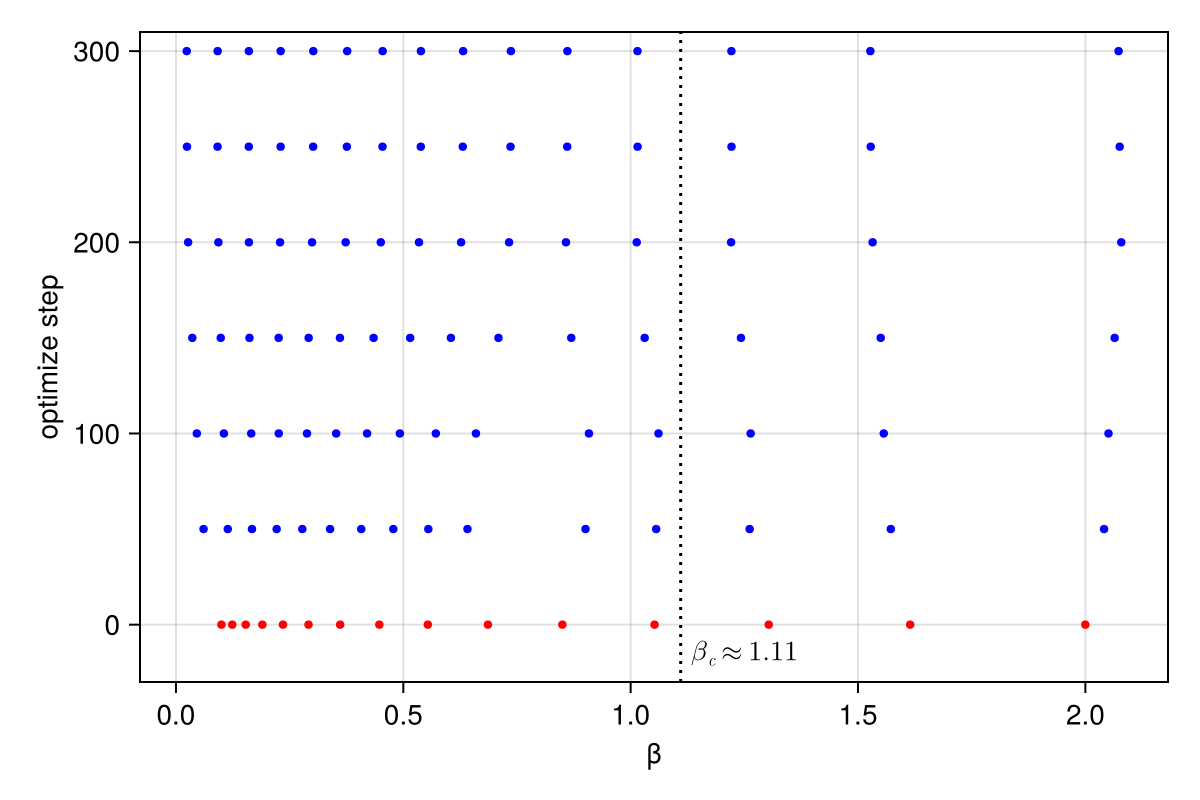

CairoMakie.Screen{IMAGE}


In [ ]:
fig = Figure(font = "Computer Modern", size = (600, 400))
ax = Axis(fig[1, 1],
    xlabel = "β",
    ylabel = "optimize step"
)
# xlims!(ax, -0.05, 2.05)
ylims!(ax, -30, epochs+10)

plot_interval = 50
for (i, β_ladder) in enumerate(β_ladder_trace)
    step = i - 1
    if step == 0 || step % plot_interval == 0
        β_values = β_ladder
        y_values = fill(step, length(β_values))
        marker_color = (step == 0) ? :red : :blue

        scatter!(ax, β_values, y_values,
            color = marker_color,
            markersize = 6,
            strokewidth = 0
        )
    end
end

# β_c = Inf # T_c=0
# vlines!(ax, [β_c], color=:black, linestyle=:dot, label="Critical βc")
text!(
    ax,
    L"\beta_c \approx %$(round(β_c, digits=3))", 
    position = (β_c, -15), 
    align = (:left, :center), 
    offset = (5, 0)
)
display(fig)
save("$dir/Evolution of the Inverse-Temperature Ladder over Optimization Epochs.png", fig; px_per_unit=4)

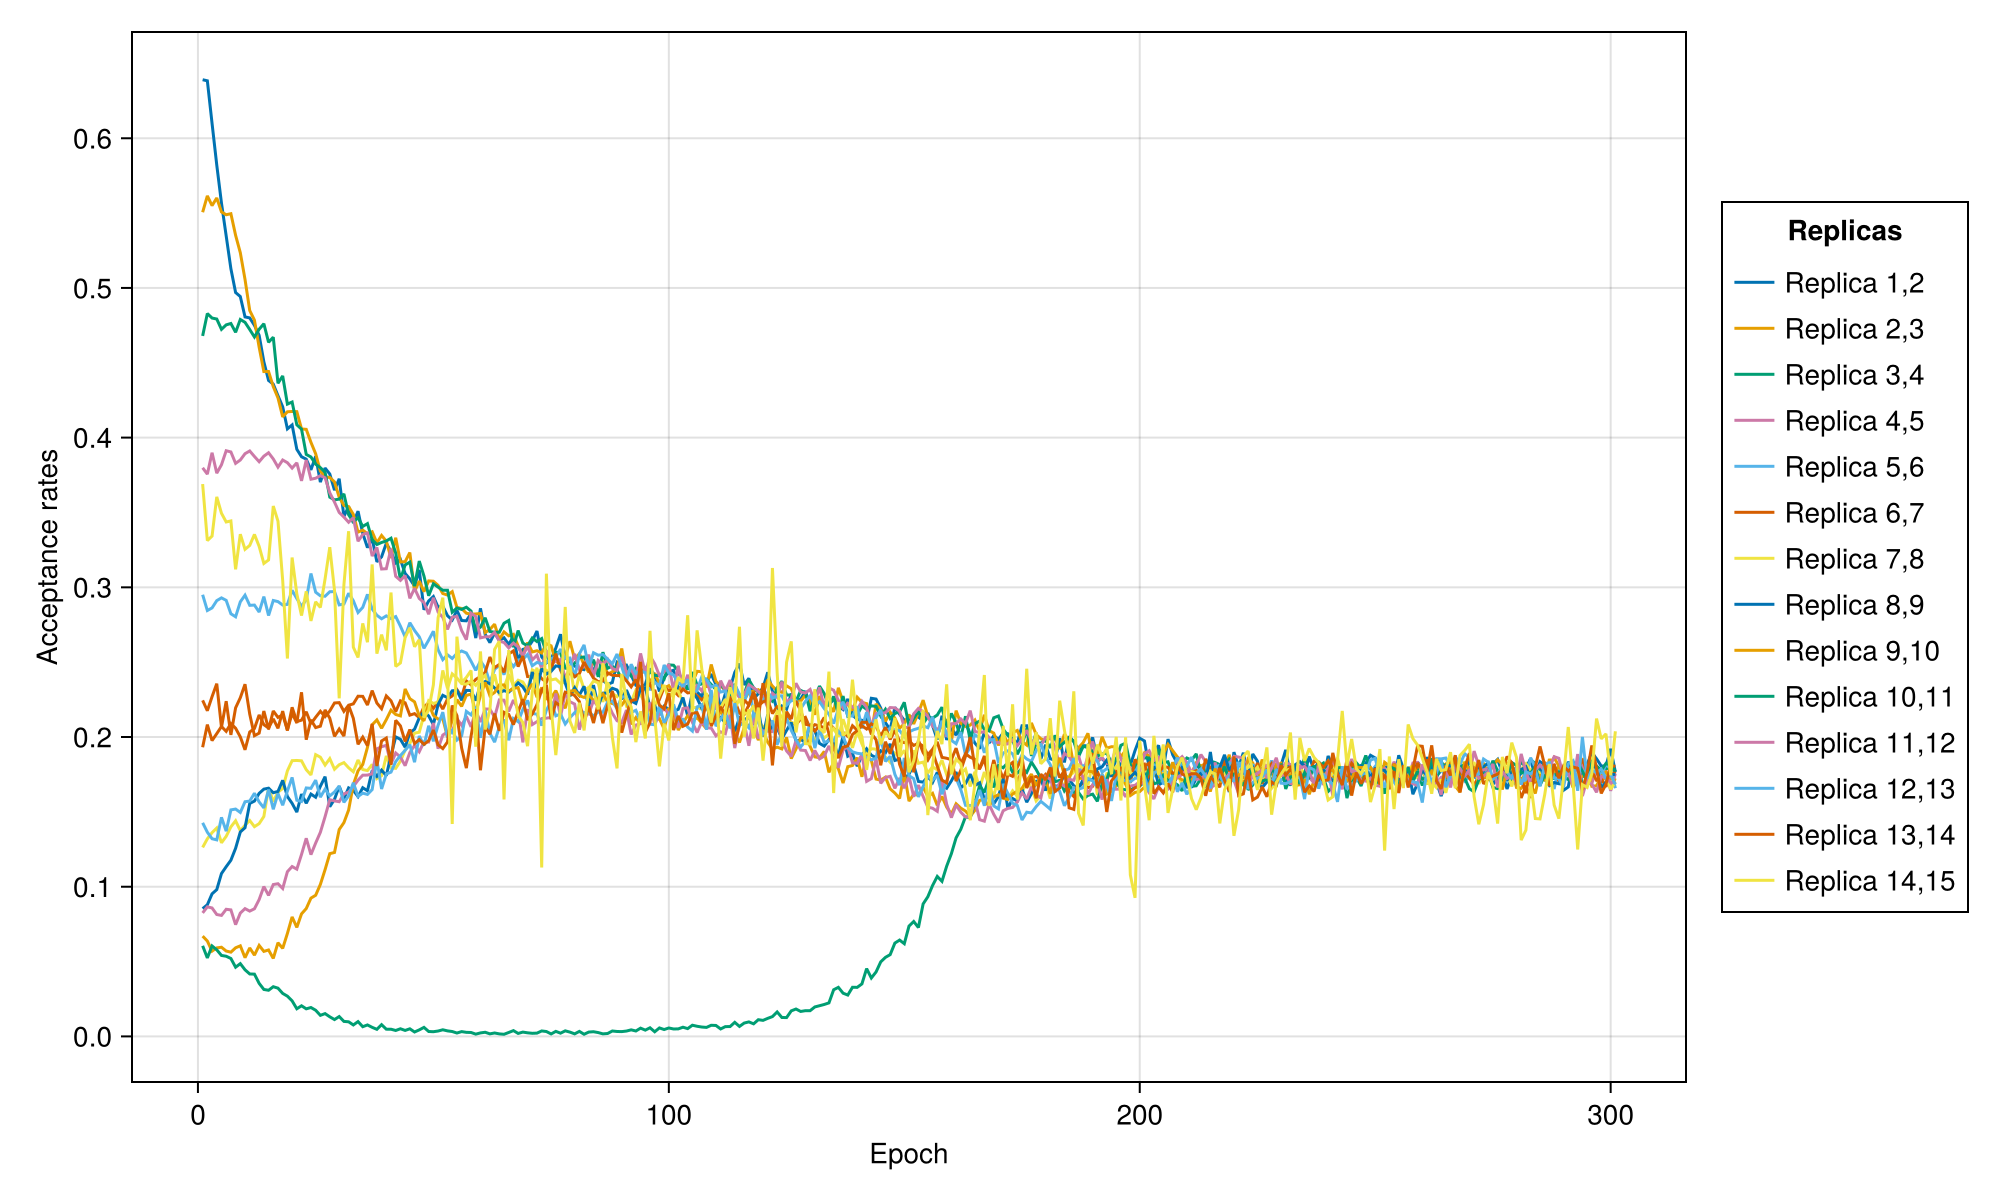

CairoMakie.Screen{IMAGE}


In [ ]:
data = hcat(exchange_prob_trace...)
fig2 = Figure(size = (1000, 600))
ax2  = Axis(
    fig2[1, 1], 
    # title = "Replica Exchange Probabilities over Epochs", 
    xlabel = "Epoch", 
    ylabel = "Acceptance rates"
)
# ylims!(ax2, 0, 1)
for i in 1:(M-1)
    lines!(ax2, 1:(epochs+1), data[i, :], label = "Replica $i,$(i+1)")
end

Legend(fig2[1, 2], ax2, "Replicas")

# axislegend(ax2; position = :rt)
display(fig2)
save("$dir/Replica Exchange Probabilities over Epochs.png", fig2; px_per_unit=4)

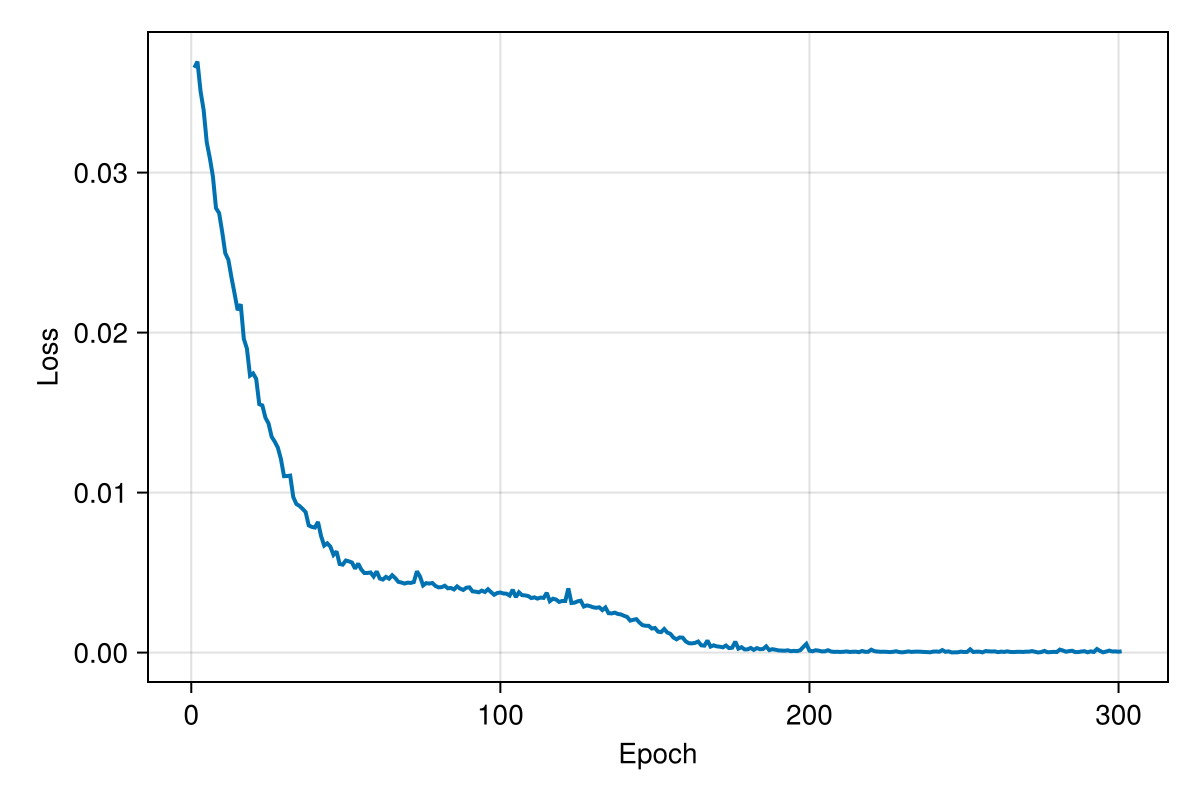

CairoMakie.Screen{IMAGE}


In [ ]:
fig3 = Figure(size = (600, 400))
ax3 = Axis(
    fig3[1, 1]; 
    # title = "Loss function", 
    xlabel = "Epoch", 
    ylabel = "Loss"
)
lines!(ax3, 1:(epochs+1), loss_trace; linewidth = 2)
# scatter!(ax3, 1:n, loss_trace; markersize = 4)

display(fig3)
save("$dir/Loss function.png", fig3; px_per_unit=4)

In [12]:
println(β_ladder_trace[end])

[0.02366366521145683, 0.09165865742510572, 0.16032938456822032, 0.2302735887583349, 0.30198538009727843, 0.3765678575208895, 0.4545109701380863, 0.5387418590933178, 0.6315456728110064, 0.7366229519001501, 0.860863079634594, 1.0150615059529287, 1.221544260033799, 1.5271857646178788, 2.0730517284257046]


In [ ]:
# fig4 = Figure(size = (600, 400))
# ax4 = Axis(fig4[1, 1]; title = "Round Trip Time", xlabel = "Epoch", ylabel = "RTT(MCS)")
# lines!(ax4, 1:(epochs+1), mean_rtt_trace; linewidth = 2)

# display(fig4)